In [106]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#Question 2 
#part a
OJ = pd.read_csv("OJ.csv") # reading in data

#splitting trainign and testing data
train, test = train_test_split(OJ, train_size=800, random_state=1)


train_l = len(train)
test_l = len(test)

In [107]:
#part b 

from sklearn.tree import DecisionTreeClassifier # importing Decision Tree tool

# Predictors vs response 
X_train = train.drop(columns=["Purchase"])
y_train = train["Purchase"]

X_train_enc = pd.get_dummies(X_train, drop_first=True)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)


#Tree fit
tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train_enc, y_train_enc)

#Ask someone what is meant by summary statistics 

# Training error rate
train_pred = tree.predict(X_train_enc)
train_error = (train_pred != y_train_enc).mean()

# Number of terminal nodes
n_leaves = tree.get_n_leaves()
print("Terminal nodes:", n_leaves)
print("Training error:", train_error)

#part c
from sklearn.tree import export_text # built in fucntion that helps answer this question

tree_text = export_text(tree, feature_names=list(X_train_enc.columns))
print(tree_text)

#Examining Terminal Node:
#SpecialCH >  0.50
#|   |   |   |--- LoyalCH <= 0.41
#|   |   |   |   |--- PriceDiff <= -0.13
#|   |   |   |   |   |--- LoyalCH <= 0.37
#|   |   |   |   |   |   |--- class: 1

# This node corresponds to people who receive promotions from CH, have low loyalty toward CH and have a price advantage for CH 
#compared to MM. With class 1 being CH, that is what is picked at this node, which makes sense as even though the person
#doesn't have much brand loyalty, there is a price advantage and they receive frequent promotions of CH> 

Terminal nodes: 164
Training error: 0.01
|--- LoyalCH <= 0.45
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.05
|   |   |   |--- StoreID <= 2.50
|   |   |   |   |--- LoyalCH <= 0.00
|   |   |   |   |   |--- LoyalCH <= 0.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- LoyalCH >  0.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- LoyalCH >  0.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- StoreID >  2.50
|   |   |   |   |--- class: 1
|   |   |--- LoyalCH >  0.05
|   |   |   |--- WeekofPurchase <= 249.50
|   |   |   |   |--- STORE <= 1.50
|   |   |   |   |   |--- WeekofPurchase <= 235.50
|   |   |   |   |   |   |--- WeekofPurchase <= 232.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- WeekofPurchase >  232.00
|   |   |   |   |   |   |   |--- SpecialCH <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- SpecialCH >  0.50
|   |   |   |   |   |   |   |   |--- LoyalCH <= 0.22
|   |   |   |  

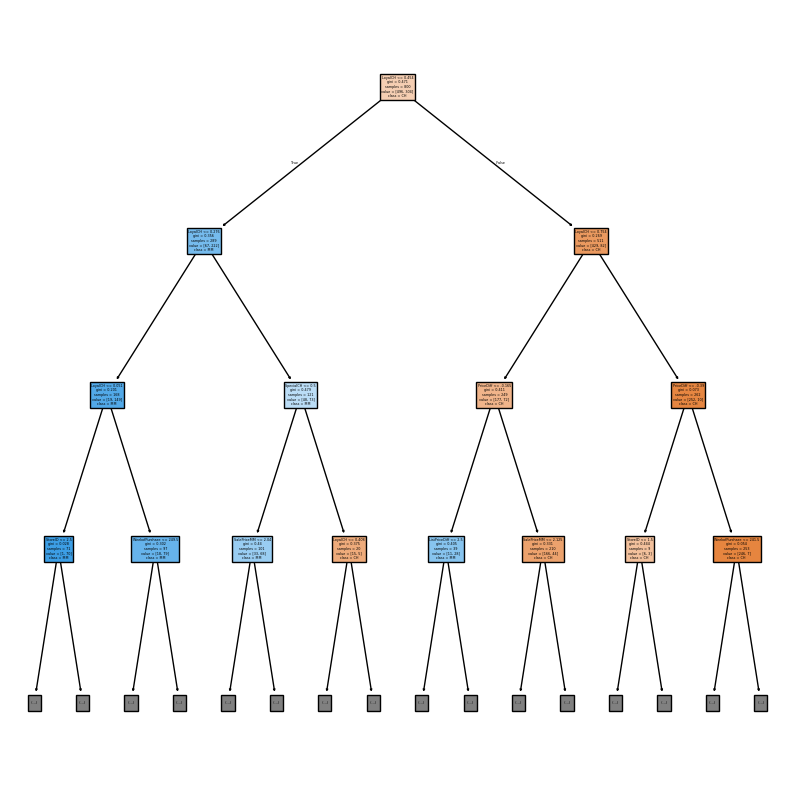

In [108]:
#part d 
from sklearn import tree as sktree # tool that helps plot decision trees specfically 
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sktree.plot_tree(tree, feature_names=list(X_train.columns),
                 class_names=["CH","MM"], filled=True, max_depth=3      )
plt.show()
#Interpretation: 
#The first split is essentially always on LoyalCH, showing that its the clearest thing in data that tells us whether someone
#is more likely to buy CH(cause they're more loyal) or less liekly to buy CH(cause they're less loyal)

In [109]:
#part e 

#creating test X and y data
X_test = test.drop(columns = ["Purchase"])
y_test = test["Purchase"]

X_test_enc = pd.get_dummies(X_test, drop_first=True)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test_enc = le.fit_transform(y_test)

#predictions
test_pred = tree.predict(X_test_enc)

from sklearn.metrics import confusion_matrix #tool that helps build confusion matrix 

matrix  = confusion_matrix(y_test_enc, test_pred)
print(matrix)
count = 0
for i in range(len(test_pred)): 
    if test_pred[i] != y_test_enc[i]:
        count = count + 1 
test_error = count/(len(test_pred))
print("Test error:", test_error)
    


[[134  23]
 [ 43  70]]
Test error: 0.24444444444444444


In [110]:
#part f 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np

path = tree.cost_complexity_pruning_path(X_train_enc, y_train_enc)
ccp_alphas = path.ccp_alphas # list of candiates that prunes tree from full to one "leaf"

tree_sizes = []
cv_errors = []

for alpha in ccp_alphas:
    classifier = DecisionTreeClassifier(random_state=1, ccp_alpha=alpha)
    
    # CV Accuracy (10-fold)
    scores = cross_val_score(classifier, X_train_enc, y_train_enc, cv=10)
    error_rate = 1 - scores.mean()   # classification error

    classifier.fit(X_train_enc, y_train_enc)

    
    #  number of leaves
    size = classifier.get_n_leaves()

    
    

    tree_sizes.append(size)
    cv_errors.append(error_rate)

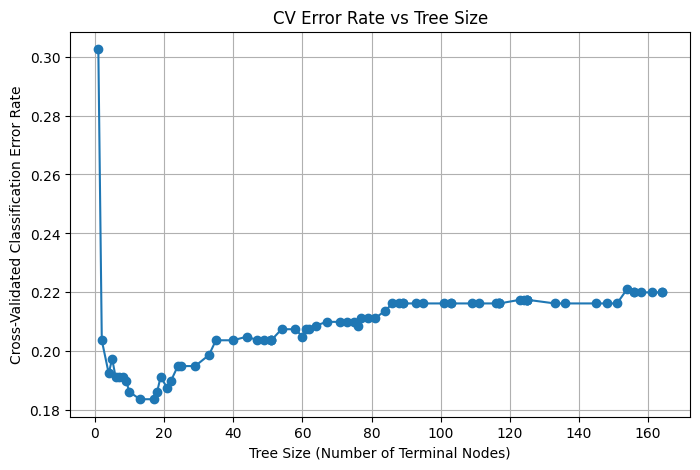

In [111]:
# part g 
plt.figure(figsize=(8, 5))
plt.plot(tree_sizes, cv_errors, marker='o')
plt.xlabel("Tree Size (Number of Terminal Nodes)")
plt.ylabel("Cross-Validated Classification Error Rate")
plt.title("CV Error Rate vs Tree Size")
plt.grid(True)
plt.show()

In [112]:
#part h 
best = np.argmin(cv_errors) #obtain index of optimal traits 

best_size = tree_sizes[best]
best_alpha = ccp_alphas[best]
best_cv_error = cv_errors[best]

print("Best tree size:", best_size)
print("Corresponding alpha:", best_alpha)
print("Lowest CV error:", best_cv_error)

#part I
#fitting optimal tree
optimal_tree = DecisionTreeClassifier(random_state=1, ccp_alpha=best_alpha)
optimal_tree.fit(X_train_enc, y_train_enc)

if best_alpha == 0:
    pruned_tree = DecisionTreeClassifier(random_state=1, max_leaf_nodes=5)
    pruned_tree.fit(X_train_enc, y_train_enc)
print("Pruned tree size:", optimal_tree.get_n_leaves())

#



Best tree size: 17
Corresponding alpha: 0.003132639419404124
Lowest CV error: 0.18375000000000008
Pruned tree size: 17


In [113]:
#part j 

unpruned_tree = DecisionTreeClassifier(random_state=1)
unpruned_tree.fit(X_train_enc, y_train_enc)

#creating pruned and unpruned trees 
train_error_unpruned = 1 - unpruned_tree.score(X_train_enc, y_train_enc)
train_error_pruned   = 1 - optimal_tree.score(X_train_enc, y_train_enc)

print("Training error (unpruned):", train_error_unpruned)
print("Training error (pruned):", train_error_pruned)

#training error of unpruned is way lower than that of pruned - because unpruned overfits, its able to predit more accruately
#on points its already trained on 

#part k 
test_error_unpruned = 1 - unpruned_tree.score(X_test_enc, y_test_enc)
test_error_pruned   = 1 - optimal_tree.score(X_test_enc, y_test_enc)

print("Test error (unpruned):", test_error_unpruned)
print("Test error (pruned):", test_error_pruned)

#test error of unpruned is higher than that of pruned - because unpruned overfits, when used on new points it tends to produce 
#farther estimates compared to pruned model

Training error (unpruned): 0.010000000000000009
Training error (pruned): 0.13749999999999996
Test error (unpruned): 0.24444444444444446
Test error (pruned): 0.18888888888888888


x: [5.85827243e-01 3.47733133e-01 6.35073595e-01 1.00811354e-01
 9.69510816e-01 6.35938872e-01 5.23799585e-02 3.20322424e-01
 2.54578463e-01 8.82017881e-01 7.40233442e-01 9.00490554e-01
 9.73115176e-01 6.02015064e-01 5.50582254e-01 5.95230702e-01
 8.21333875e-01 3.66620094e-01 9.68375721e-01 6.55772876e-01
 5.55335961e-01 8.24389715e-01 2.58012278e-01 7.59966977e-01
 8.35340349e-01 1.87217738e-01 3.24604210e-01 7.11342974e-01
 1.52634918e-01 9.22888147e-02 8.51858420e-02 2.34147579e-01
 6.07139489e-01 8.01100690e-02 8.27560042e-01 6.39804801e-01
 2.19505482e-01 5.92773245e-03 7.66695482e-01 7.91779759e-01
 8.28183661e-01 9.02139806e-01 5.37336997e-01 7.19635255e-01
 4.36295294e-01 8.93196086e-01 9.41181978e-02 6.33836125e-02
 4.91419863e-01 9.51291207e-01 9.25863183e-02 9.55786341e-01
 8.54316191e-01 3.37162061e-01 5.52835545e-01 6.92710914e-01
 8.40268114e-01 2.26607557e-01 1.01633983e-01 7.02915770e-01
 6.55019050e-01 8.78159213e-01 4.61530038e-01 4.79845565e-01
 7.04609590e-01 1.974

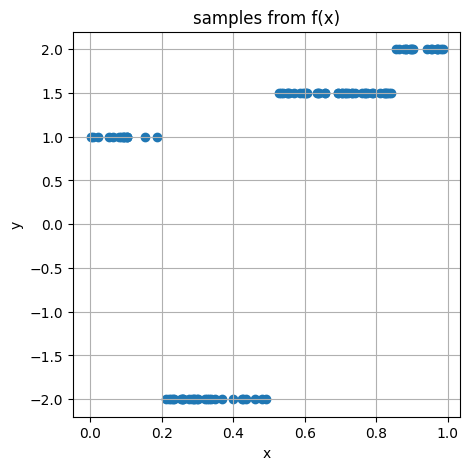

In [114]:
#Question 3 

# function described in problem 
def f(x):
    if 0 <= x < 0.2:
        return 1.0
    elif 0.2 <= x < 0.5:
        return -2.0
    elif 0.5 <= x < 0.85:
        return 1.5
    elif 0.85 <= x <= 1.0:
        return 2.0
    else:
        raise ValueError("x out of bounds")

N = 100
x = np.random.rand(N)
y_list = []
for i in x:
    y_list.append(f(i))
y = np.array(y_list)
print("x:", x)
print("y:", y)


#part b 

#creating graph 
plt.figure(figsize=(5, 5))
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('samples from f(x)')
plt.grid(True)
plt.show()

minimum split: 0.49385964912280705


/var/folders/6w/fghtg3m506x56jzbygbk_d780000gn/T/ipykernel_69864/3609380812.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


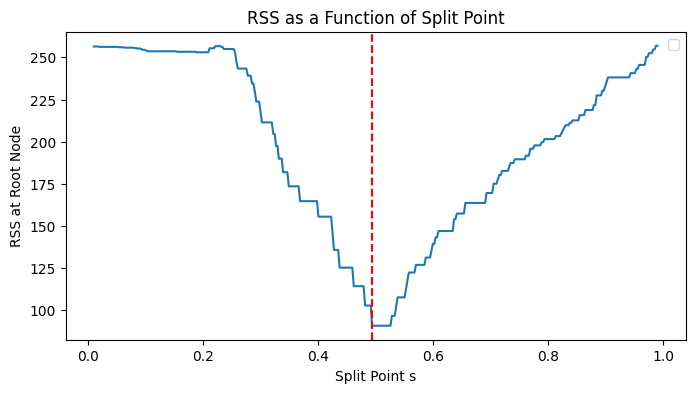

Training RSS: 0.0
Number of leaves: 4
Textual tree:
|--- x <= 0.51
|   |--- x <= 0.20
|   |   |--- value: [1.00]
|   |--- x >  0.20
|   |   |--- value: [-2.00]
|--- x >  0.51
|   |--- x <= 0.85
|   |   |--- value: [1.50]
|   |--- x >  0.85
|   |   |--- value: [2.00]



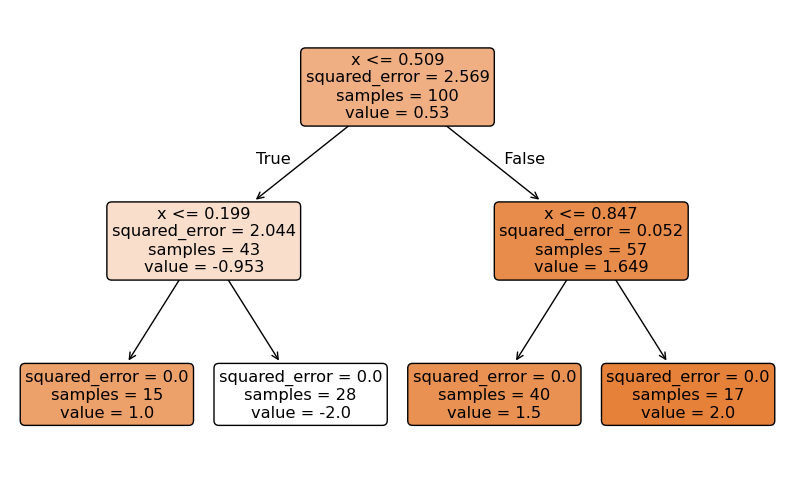

In [117]:
#part d 

s_grid = np.linspace(0.01, 0.99, 400)
rss_vals = []

for s in s_grid:
    left = y[x < s]
    right = y[x >= s]
    
    # compute RSS in each region
    rss_left = np.sum((left - left.mean())**2) if len(left) > 0 else 0
    rss_right = np.sum((right - right.mean())**2) if len(right) > 0 else 0

    rss_vals.append(rss_left + rss_right)

s_min = s_grid[np.argmin(rss_vals)]
print("minimum split:", s_min)
#Answer: Yes it actually seems to be minimized between .2 and .5. 
plt.figure(figsize=(8,4))
plt.plot(s_grid, rss_vals)
plt.axvline(s_min, color='red', linestyle='--')
plt.xlabel("Split Point s")
plt.ylabel("RSS at Root Node")
plt.title("RSS as a Function of Split Point")
plt.legend()
plt.show()


#part e

from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree


# Fit regressor with exactly up to 4 leaves
reg = DecisionTreeRegressor(random_state=1, max_leaf_nodes=4)
reg.fit(x.reshape(-1,1), y) 

# Predictions and training RSS
y_pred = reg.predict(x.reshape(-1,1))
train_rss = ((y - y_pred)**2).sum()
print("Training RSS:", train_rss)
print("Number of leaves:", reg.get_n_leaves())

#Answer: The training RSS is indeed 0, and the minimum split is around .5, which is one of our breakpoints. 

# Show textual tree (thresholds)
print("Textual tree:")
print(export_text(reg, feature_names=['x']))

# plotting the tree
plt.figure(figsize=(10,6))
plot_tree(reg, feature_names=['x'], filled=True, rounded=True)
plt.show()

#part c and f on paper 

In [116]:
#Question 4(check this)

import pandas as pd
from statsmodels.datasets import get_rdataset

# Load Caravan from ISLR
caravan = pd.read_csv("Caravan.csv")


#part a
# Training: first 1000 rows
train = caravan.iloc[:1000].copy()
test = caravan.iloc[1000:].copy()


# Predictors
X_train = train.drop(columns=["Purchase"])
X_test = test.drop(columns=["Purchase"])

y_train = train["Purchase"]
y_test = test["Purchase"]


# Response variable
y_train = (train["Purchase"] == "Yes").astype(int)
y_test = (test["Purchase"] == "Yes").astype(int)

#part b
from sklearn.ensemble import GradientBoostingClassifier

boost = GradientBoostingClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=1,       # ISLR uses stumps for boosting
    random_state=1
)

boost.fit(X_train, y_train)


#determine the most important features
feature_importance = pd.Series(
    boost.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

print(feature_importance.head(15))

#It appears that the most important predictors/features are the 15 listed below 

PPERSAUT    0.232158
PPLEZIER    0.115622
APLEZIER    0.099386
MKOOPKLA    0.079352
AWAOREG     0.052456
MBERMIDD    0.050468
MOPLHOOG    0.045783
PWAOREG     0.045412
AMOTSCO     0.041353
PBRAND      0.036588
MSKB1       0.023056
PZEILPL     0.019795
ABRAND      0.019041
PMOTSCO     0.018187
MGODOV      0.016980
dtype: float64


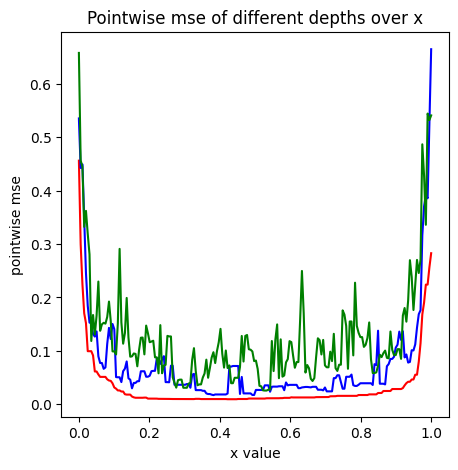

In [92]:
#Question 5 

#part a 
#Generating training data and problem setup
np.random.seed(0)
N = 200
y = 1 + np.random.randn(N)
f_true = 1 # Given in problem 
X = np.random.uniform(0, 1, N).reshape(-1, 1)

#part b 
x2 = np.linspace(0,1, 200).reshape(-1,1)
depths = [1, 2, 3]
reps = 100 #repition to stabilize averages 

#initialzing mse storing array
mse = {}

#For each repetition, we generate a new dataset and fit a tree of a certain depth, and then predict the tree output on our x's
for i in depths: 
    preds = np.zeros((reps, 200))
    for j in range(reps):
        xj = np.random.uniform(0,1, N).reshape(-1,1)
        yj = 1 + np.random.randn(N)
        tree = DecisionTreeRegressor(max_depth = i)
        tree.fit(xj, yj)
        preds[j] = tree.predict(x2)
    mse[i] = ((preds - f_true)**2).mean(axis = 0)
plt.figure(figsize =(5,5))
#plotting each mse with different colors 
colors = ['red', 'blue', 'green']
for c,i in zip(colors, depths): 
    plt.plot(x2, mse[i], label = str(i), color = c)
plt.xlabel("x value")
plt.ylabel("pointwise mse")
plt.title("Pointwise mse of different depths over x")
plt.show()

#BE SURE TO MAKE OBSERVATIONS 

#From the graph, I noticed that the larger the depth, the higher the pointwise MSE is on average(at least for most values of x)


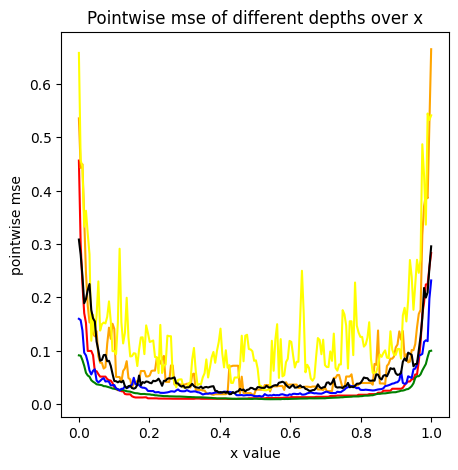

In [96]:
#part c 
from sklearn.utils import resample #EXPLAIN

B = 30 # bagging number of trees
bagged_mse = {d: np.zeros(200) for d in depths}

#Essentially the same thing as last part, but fitting the bagged component- baggining averages many trees on samples that are bootstrapped
for i in depths:
    preds = np.zeros((reps, 200))
    for j in range(reps): 
        Xj = np.random.uniform(0, 1, N).reshape(-1, 1)
        yj = 1 + np.random.randn(N)
        bagged_preds = np.zeros((B, 200))
        for k in range(B):
            Xk, yk = resample(Xj, yj)
            tree = DecisionTreeRegressor(max_depth = i)
            tree.fit(Xk, yk)
            bagged_preds[k] = tree.predict(x2)
        preds[j] =  bagged_preds.mean(axis=0)
    bagged_mse[i] = ((preds - f_true)**2).mean(axis = 0)
plt.figure(figsize =(5,5))
color1 = [ 'red', 'orange', 'yellow']
color2 = [ 'green', 'blue', 'black']
for c1, c2, i in zip(color1, color2, depths): 
    plt.plot(x2, mse[i], color = c1)
    plt.plot(x2, bagged_mse[i], color = c2 )
plt.xlabel("x value")
plt.ylabel("pointwise mse")
plt.title("Pointwise mse of different depths over x")
plt.show()

#From the graph below, it appears that a bagged tree preidctor has a smaller pointwise MSE than a decision tree


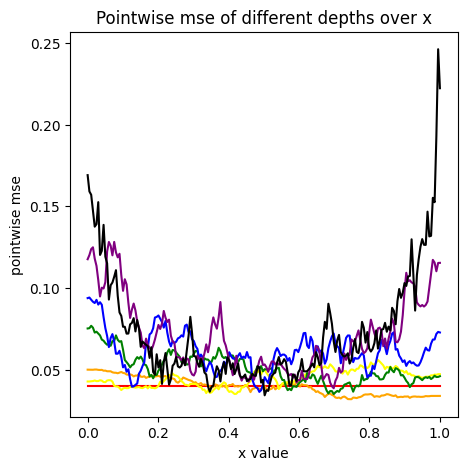

In [104]:
#part d
s_range = [1, 2, 4, 8, 16, 32, 64]
mse_sample = {}
#Here we are bagging without replacement, and incremntally building up the sample size we bag with-similar code as before though
for i in s_range:
    preds = np.zeros((reps, 200))
    for j in range(reps): 
        Xj = np.random.uniform(0, 1, N).reshape(-1, 1)
        yj = 1 + np.random.randn(N)
        s_preds = np.zeros((B, 200))
        for k in range(B):
            index = np.random.choice(np.arange(N), size=i, replace=False)
            tree = DecisionTreeRegressor(max_depth = 4)
            tree.fit(Xj[index], yj[index])
            s_preds[k] = tree.predict(x2)
        preds[j] =  s_preds.mean(axis=0)
    mse_sample[i] = ((preds - f_true)**2).mean(axis = 0)
plt.figure(figsize =(5,5))
color3 = [ 'red', 'orange', 'yellow','green', 'blue','purple', 'black' ]
for c, i in zip(color3, s_range): 
    plt.plot(x2, mse_sample[i], color = c)
plt.xlabel("x value")
plt.ylabel("pointwise mse")
plt.title("Pointwise mse of different depths over x")
plt.show()
#When varying the parameter s, I noticed that the larger s gets, the higher and more variable the pointwise mse becomes over the values of x 